# Workflow

1. Import and Preprocessing
2. Dataset exploration
3. Co-occurrence matrix construction
4. Graph
5. Plots
6. Report

<a id="loadlibraries"></a>
# `Load Libraries`
---

# ❓ Why are these libraries useful?
 We need tools for data manipulation (pandas, numpy), visualization (matplotlib, seaborn),
graph analysis (networkx), and structure handling (collections, itertools)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
from itertools import combinations
from collections import Counter
import warnings
from networkx.algorithms.community import greedy_modularity_communities

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

<a id="loadlibraries"></a>
# ` Load and Preprocess Dataset`
---

# ❓ Why do we transform to long format?
To facilitate aggregation and filtering of document-term relations.

In [63]:
print("Loading dataset...")
df = pd.read_csv("02_terms.csv")
df.head()

# each row is a document. Binary values indicate if there are in the document or not

Loading dataset...


,DocNumber,advice,author,cold,computing,encourage,examples,information,help,lesson,...,positions,proposal,recommend,research,sentiment,slides,suggestion,tip,tutorial,users
0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,5,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [64]:
print("\n--- Dataset Overview ---")
print("Shape:", df.shape)
print("Column types:\n", df.dtypes)




--- Dataset Overview ---
Shape: (153, 22)
Column types:
 DocNumber      int64
advice         int64
author         int64
cold           int64
computing      int64
encourage      int64
examples       int64
information    int64
help           int64
lesson         int64
news           int64
opinion        int64
positions      int64
proposal       int64
recommend      int64
research       int64
sentiment      int64
slides         int64
suggestion     int64
tip            int64
tutorial       int64
users          int64
dtype: object


In [65]:
df.head()

,DocNumber,advice,author,cold,computing,encourage,examples,information,help,lesson,...,positions,proposal,recommend,research,sentiment,slides,suggestion,tip,tutorial,users
0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,5,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [66]:
df.columns


Index(['DocNumber', 'advice', 'author', 'cold', 'computing', 'encourage',
       'examples', 'information', 'help', 'lesson', 'news', 'opinion',
       'positions', 'proposal', 'recommend', 'research', 'sentiment', 'slides',
       'suggestion', 'tip', 'tutorial', 'users'],
      dtype='object')

In [67]:
# Transform to long format for easier analysis
df_long_format = df.melt(id_vars=['DocNumber'], 
                  var_name='term', 
                  value_name='frequency')
# Rename columns for clarity
df_long_format.columns = ['document_id', 'term', 'frequency']

# Remove rows with frequency zero (term not present)
df_long = df_long_format[df_long_format['frequency'] > 0]

# Reset index
df_long.reset_index(drop=True, inplace=True)

df_long.head()



,document_id,term,frequency
0,16,advice,1
1,18,advice,1
2,19,advice,1
3,20,advice,1
4,21,advice,1


In [68]:
# Display information about the transformed data
print("Transformed data (first 5 rows):")
print(df_long.head())
print("\n➡️ Total number of rows:", df_long.shape[0])
print("➡️ Number of documents:", df_long['document_id'].nunique())
print("➡️ Number of terms:", df_long['term'].nunique())
print("➡️ Null values:", df_long.isnull().sum().sum())


Transformed data (first 5 rows):
   document_id    term  frequency
0           16  advice          1
1           18  advice          1
2           19  advice          1
3           20  advice          1
4           21  advice          1

➡️ Total number of rows: 400
➡️ Number of documents: 139
➡️ Number of terms: 21
➡️ Null values: 0


<a id="loadlibraries"></a>
# ` Explore Dataset`
---

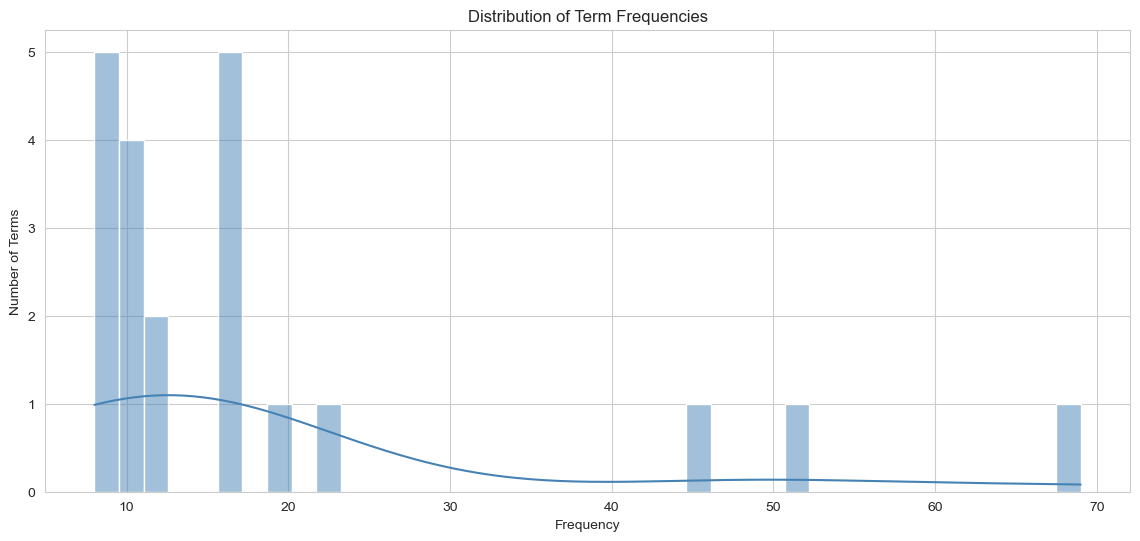

In [83]:
# ❓ What is the distribution of term usage?
term_freq = df_long.groupby('term')['frequency'].sum().sort_values(ascending=False)

# Histogram
plt.figure(figsize=(14, 6))
sns.histplot(term_freq, bins=40, kde=True, color='steelblue')
plt.title('Distribution of Term Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.grid(True)
plt.show()



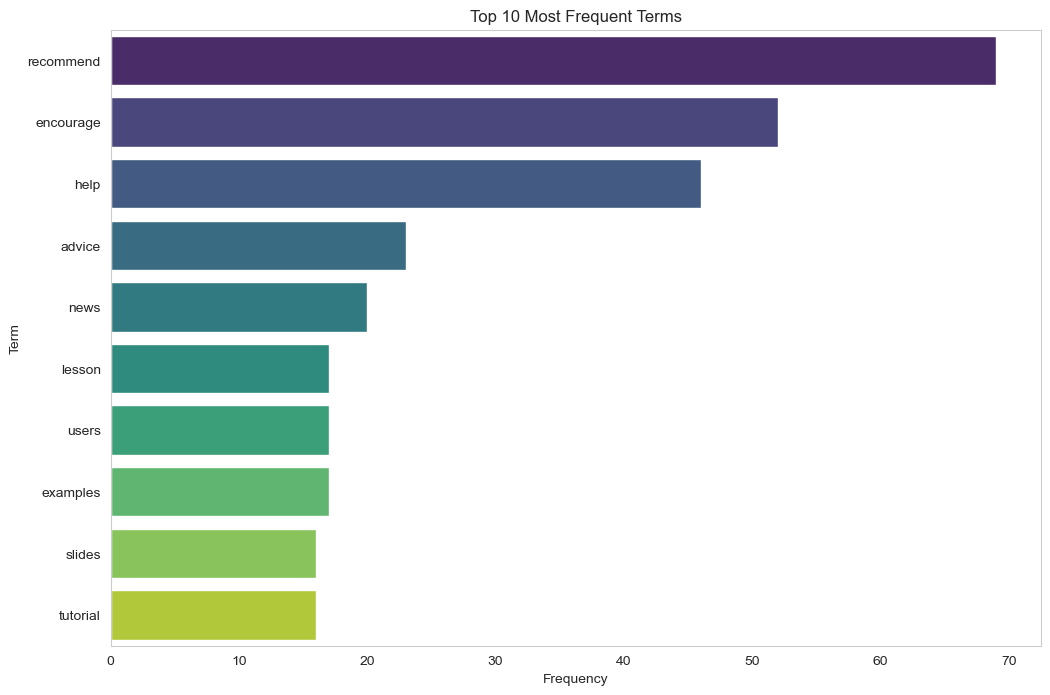

In [84]:
# Top 10 terms
plt.figure(figsize=(12, 8))
sns.barplot(x=term_freq.head(10).values, y=term_freq.head(10).index, palette='viridis')
plt.title('Top 10 Most Frequent Terms')
plt.xlabel('Frequency')
plt.ylabel('Term')
plt.grid(axis='x')
plt.show()



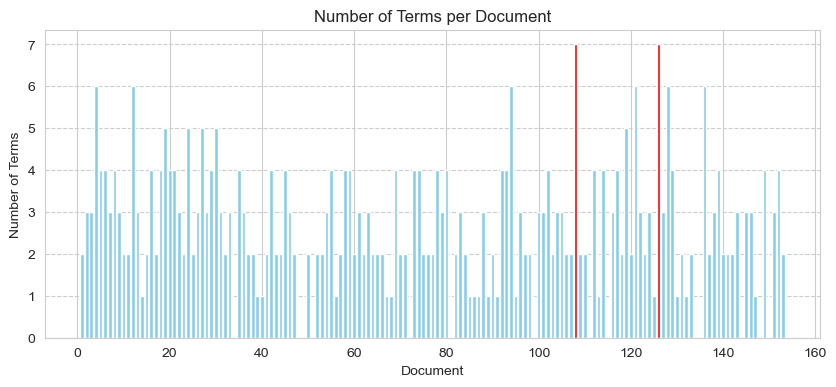

In [85]:
# ❓ Which documents are most populated with terms?
doc_term_count = df_long.groupby('document_id').size().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
colors = ['red' if val == doc_term_count.max() else 'skyblue' for val in doc_term_count]
plt.bar(doc_term_count.index, doc_term_count.values, color=colors)
plt.title('Number of Terms per Document')
plt.xlabel('Document')
plt.ylabel('Number of Terms')
plt.grid(axis='y', linestyle='--')
plt.show()

<a id="loadlibraries"></a>
# ` Co-occurrence Matrix`
---

# ❓ Why compute co-occurrences?
 To discover terms that often appear together, indicating a semantic or topical connection

In [90]:
print("\n--- Co-occurrence Analysis ---")
# Group by document to get list of terms in each document
doc_term_map = df_long.groupby('document_id')['term'].apply(list)

# Calculate term co-occurrences
co_occurrence = Counter()
for terms in doc_term_map:
    # Use set to avoid counting duplicates within the same document
    pairs = combinations(set(terms), 2)
    co_occurrence.update(pairs)

# Convert to DataFrame
co_df = pd.DataFrame(co_occurrence.items(), columns=['pair', 'count'])
co_df[['term1', 'term2']] = pd.DataFrame(co_df['pair'].tolist(), index=co_df.index)
co_df.drop(columns=['pair'], inplace=True)
co_df = co_df[['term1', 'term2', 'count']]

# Display the strongest co-occurrences
print("Top 10 strongest term co-occurrences:")
print(co_df.sort_values(by='count', ascending=False).head(10))

# Find least connected terms
if co_df['count'].min() == 0:
    least_connected = co_df[co_df['count'] == 0].head(5)
else:
    least_connected = co_df.sort_values(by='count').head(5)
    
print("\nLeast connected term pairs:")
print(least_connected)


--- Co-occurrence Analysis ---
Top 10 strongest term co-occurrences:
        term1       term2  count
29       help   encourage     33
23  encourage   recommend     21
31       help   recommend     19
8       users   recommend     13
75   examples   recommend     13
39     lesson      advice     12
21       news   recommend     11
41     lesson  suggestion     11
55     advice   recommend     11
4   recommend   computing      9

Least connected term pairs:
        term1        term2  count
151  tutorial          tip      1
107  examples  information      1
108  tutorial       slides      1
57     advice  information      1
110  tutorial       advice      1


<a id="loadlibraries"></a>
# ` Network Graph Analysis `
---

In [92]:

G = nx.Graph()

# Add nodes (terms)
terms = pd.unique(co_df[['term1', 'term2']].values.ravel('K'))
G.add_nodes_from(terms)

# Add edges (co-occurrences)
for _, row in co_df.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['count'])

print(f"Nodes in graph: {G.number_of_nodes()}")
print(f"Edges in graph: {G.number_of_edges()}")


Nodes in graph: 21
Edges in graph: 128


In [93]:
# Metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
communities = list(greedy_modularity_communities(G))

nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')

community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i
nx.set_node_attributes(G, community_map, 'community')


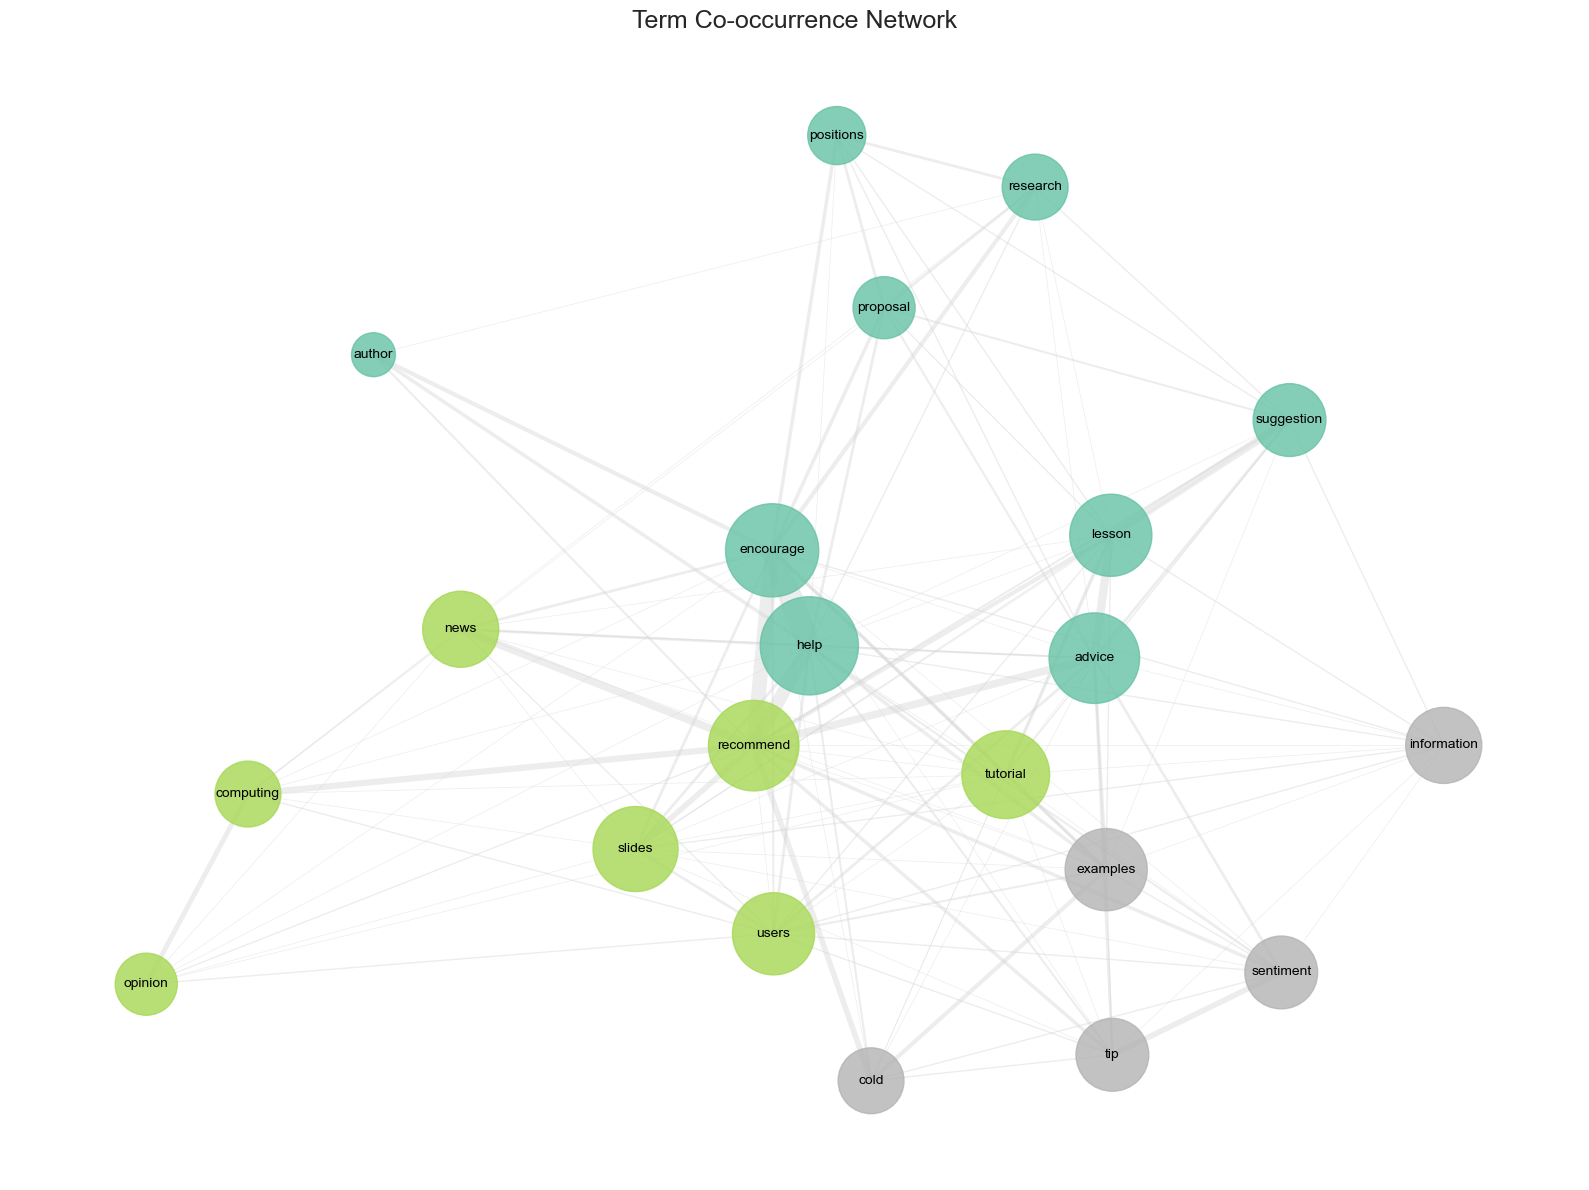

In [95]:

plt.figure(figsize=(16, 12))

# Set node positions using spring layout
layout = nx.spring_layout(G, seed=42, k=0.5)

# Color nodes by community
colors = [community_map[node] for node in G.nodes()]

# Size nodes by degree centrality
sizes = [5000 * degree_centrality[node] for node in G.nodes()]

# Draw nodes
nx.draw_networkx_nodes(G, layout,
                       node_color=colors,
                       node_size=sizes,
                       cmap=plt.cm.Set2,
                       alpha=0.8)

# Draw edges with width based on weight
edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
nx.draw_networkx_edges(G, layout, 
                       width=edge_weights,
                       edge_color='lightgray', 
                       alpha=0.4)

# Draw labels
nx.draw_networkx_labels(G, layout,
                        font_size=10,
                        font_family='sans-serif')

plt.title("Term Co-occurrence Network", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

<a id="loadlibraries"></a>
# ` HeatMap `
---

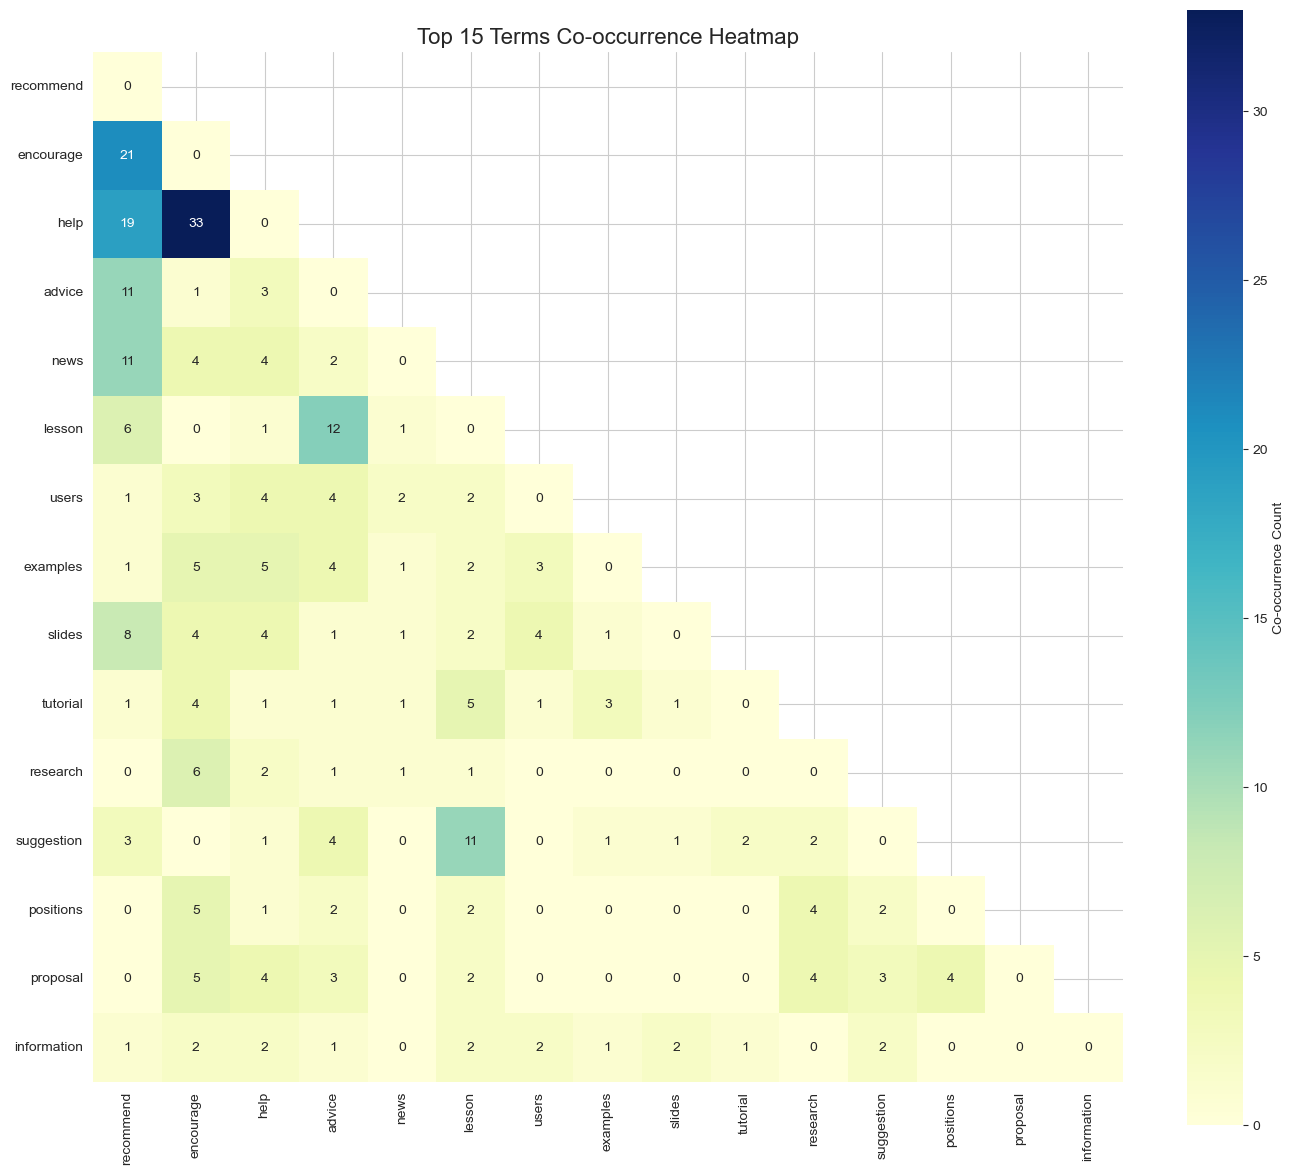

In [97]:


# Get top N terms by frequency
top_n_terms = 15
top_terms_list = term_freq.head(top_n_terms).index.tolist()

# Create an empty square matrix for co-occurrences
co_matrix = np.zeros((top_n_terms, top_n_terms))

# Create a dictionary for fast lookup
term_to_index = {term: i for i, term in enumerate(top_terms_list)}

# Fill the matrix with co-occurrence counts
for _, row in co_df.iterrows():
    term1, term2 = row['term1'], row['term2']
    count = row['count']
    
    # Check if both terms are in our top terms list
    if term1 in term_to_index and term2 in term_to_index:
        i = term_to_index[term1]
        j = term_to_index[term2]
        co_matrix[i, j] = count
        co_matrix[j, i] = count  # Make it symmetric

# Create a DataFrame from the matrix
co_matrix_df = pd.DataFrame(co_matrix, index=top_terms_list, columns=top_terms_list)

# Plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(co_matrix_df, dtype=bool), k=1)  # Mask for lower triangular
sns.heatmap(
    co_matrix_df, 
    annot=True, 
    fmt='.0f',
    cmap='YlGnBu',
    mask=mask,  # Optional: use only lower triangle due to symmetry
    square=True,
    cbar_kws={'label': 'Co-occurrence Count'}
)
plt.title(f'Top {top_n_terms} Terms Co-occurrence Heatmap', fontsize=16)
plt.tight_layout()
plt.show()  # Add explicit show() to ensure it's displayed
plt.close()



In [102]:
print("\n--- Summary ---")
print(f"    Most frequent term: {term_freq.idxmax()} ({term_freq.max()} times)")
print(f"    Most central term (degree): {max(degree_centrality.items(), key=lambda x: x[1])}")
print(f"    Most central term (betweenness): {max(betweenness_centrality.items(), key=lambda x: x[1])}")
strongest = co_df.sort_values(by='count', ascending=False).iloc[0]
print(f"    Strongest pair: {strongest['term1']} + {strongest['term2']} ({strongest['count']})")
print(f"    Number of communities: {len(communities)}")
print(f"    Largest community size: {len(max(communities, key=len))}")
print(f"    Average number of terms per document: {doc_term_count.mean():.2f}")



--- Summary ---
    Most frequent term: recommend (69 times)
    Most central term (degree): ('help', 1.0)
    Most central term (betweenness): ('help', 0.09567428185849239)
    Strongest pair: help + encourage (33)
    Number of communities: 3
    Largest community size: 9
    Average number of terms per document: 2.88
